In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import scipy.optimize
from scipy.stats import rv_continuous, norm, beta, gamma
from abc import ABC, abstractmethod
import pprint
from scipy.ndimage import gaussian_filter

In [2]:
class Base(ABC):
    @staticmethod
    @abstractmethod
    def forward(x:np.array, params:np.array)->np.array:
        pass
    @abstractmethod
    def find_priors(self,data:np.array)->None:
        pass
    
    def log_likelihood(self, x, y, params):
        return -np.sum((y - self.forward(x, params)) ** 2)
    
    @abstractmethod
    def log_prior(self, params):
        pass
    
    
    def loss(self, params, x, y, use_priors=False):
        l = -self.log_likelihood(x, y, params)
        if use_priors:
            l = l - self.log_prior(params)
        return l

In [3]:
class GaussianModel(Base):
    param_guesses: np.ndarray = np.array([.75, .5, .1,.2]) #amp, mean, sigma,offset
    param_bounds: np.ndarray = np.array([[0.01,1.],[.01,1.],[0.01,5.],[0.01,1.]]) 

    def __init__(self,distribution_data):
        self.distribution_data =  distribution_data
        self.find_priors(self.distribution_data)
        
    def find_priors(self,data):
        '''do initial guesses based on data and make distribution from that guess, very rough first pass'''
        offset = float(np.min(data))
        ampl = 1 - offset
        mean = np.argmax(data)/(len(data))
        sigma = .1
        print( ampl, mean, sigma, offset)
        
        self.init_priors = [ampl,mean,sigma,offset]
        
        self.offset_prior = norm(offset, .5)
        #self.ampl_prior = norm(ampl,1)
        mean_ampl = 0.8
        var_ampl = 0.05
        alpha = (mean_ampl**2)/var_ampl
        beta = mean_ampl/var_ampl
        self.ampl_prior = gamma(alpha, loc = 0, scale = 1/beta)
        self.mean_prior = norm(mean,0.1)
        #self.sigma_prior = norm(sigma,1)
        
        
        #a/b = .5
        #a/(b**2) = 2.5
        #a/(b**2) - a/b = 2.0
        sigma_alpha = 2.5
        sigma_beta = 5.0#sigma_alpha/sigma
        self.sigma_prior = gamma(sigma_alpha,loc=0,scale = 1/sigma_beta)
        #### change type hints in base class after returning array
    
    
    @staticmethod
    def forward(x, params):
        # unpack params
        amplitude = params[0]
        mean = params[1]
        sigma = params[2]
        offset = params[3]
        return amplitude * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2)) + offset
    
    def log_prior(self, params):
        return self.ampl_prior.logpdf(params[0]) + self.mean_prior.logpdf(params[1]) + self.sigma_prior.logpdf(params[2]) + self.offset_prior.logpdf(params[3])
    
    #takes some x and returns the amplitude of the distributions at x s
    
    def plot_priors(self):
        fig, axs = plt.subplots(4,1,figsize = (10,10))
        
        ax = axs[0]
        x = np.linspace(0,1,len(self.distribution_data))
        ax.plot(x, self.ampl_prior.pdf(x))
        #ax.axvline(self.param_bounds[0,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[0,1], ls='--', c='k', label='bounds')
        ax.set_title('Ampl Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mathrm{A}$')
        
        ax = axs[1]

        ax.plot(x, self.mean_prior.pdf(x))
        #ax.axvline(self.param_bounds[1,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[1,1], ls='--', c='k', label='bounds')
        ax.set_title('Mean Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mu$')

        ax = axs[2]
        sig_linspace = np.linspace(0,5,len(self.distribution_data))
        ax.plot(sig_linspace, self.sigma_prior.pdf(sig_linspace))
        #ax.axvline(self.param_bounds[2,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[2,1], ls='--', c='k', label='bounds')
        ax.set_xlabel('x')
        ax.set_title('Sigma Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\sigma$')
        
        ax = axs[3]
        ax.plot(x, self.sigma_prior.pdf(x))
        #ax.axvline(self.param_bounds[3,0], ls='--', c='k',)
        #ax.axvline(self.param_bounds[3,1], ls='--', c='k', label='bounds')
        ax.set_xlabel('x')
        ax.set_title('Offset Prior')
        ax.set_ylabel('Density')
        ax.set_xlabel(r'$\mathrm{Offset}$')


        fig.tight_layout()
        
    def plot_initial_guess(self):
        x_fit = np.linspace(0,1,len(self.distribution_data))
        y_fit = self.forward(x_fit,self.init_priors)
        plt.plot(x_fit,self.distribution_data, label = 'Projection Data')
        plt.plot(x_fit,y_fit, label = 'Guess Fit')
        plt.show()

In [4]:
class Image(object):
    def __init__(self, image:np.ndarray,image_name:'str'):
        self.image_name = image_name
        self.image = image

    @property
    def image(self):
        """Image, typically numpy array or 2darray"""
        print('getting image')
        return self._image

    @image.setter
    def image(self,img):
        print('setting image')
        if not isinstance(img, np.ndarray):
            raise TypeError("Input must be ndarray")
        self._image = img
        self.set_projections(img)
   
    def set_projections(self,img):
        print("Calculating X and Y Projections")
        self.x_projection = np.array(np.sum(img,axis=0))
        print(type(self.x_projection))
        self.y_projection = np.array(np.sum(img,axis=1))
        
    def subtract_image_background(self,threshold):
        self.image = np.clip(self.image-threshold,0,1e7)
        plt.imshow(self.image>0)
        plt.colorbar()


In [5]:
class Transformer_1D:
    def __init__(self,data:np.array,transform_type:str = 'normalize'):
        possible_transformations = ['normalize','standardize']
        assert transform_type in possible_transformations
        self.ttype = transform_type
        assert len(data.shape) == 1
        if not isinstance(data, np.ndarray):
            raise TypeError("Input must be np.array")    
        self.data = data
        self._get_stats()
        
    def _get_stats(self):
        if self.ttype == 'normalize':
            self.max = np.max(self.data)
        elif self.ttype == 'standardize':
            self.mean = np.mean(self.data)
            self.std = np.std(self.data)

    def recalculate(self, data):
        """Change transformer data and recalculate stats"""
        self.data = data
        self._get_stats()

    def forward(self, data_old):
        """If x_old is a torch tensor get numpy array from it"""
        if not isinstance(data_old, np.ndarray):
            raise TypeError("Input must be np.array")   
        assert len(data_old.shape) == 1
        
        if self.ttype == 'normalize':
            data = data_old/self.max
        elif self.ttype == 'standardize':
            data = (data_old - self.mean)/self.std
        return data

    
    def backward(self, data_old):
        if not isinstance(data_old, np.ndarray):
            raise TypeError("Input must be np.array")   
        assert len(data_old.shape) == 1

        if self.ttype == 'normalize':
            data = data*self.max
        elif self.ttype == 'standardize':
            data = data*self.std + self.mean
        return data

In [6]:
def fit_model(x, y, model, use_priors, plot=True):
    res =  scipy.optimize.minimize(model.loss, model.param_guesses,
                                   args=(x, y, use_priors),
                                   bounds=model.param_bounds)
    #method = "Powell"
    #bounds=model.param_bounds bad fit when bounds included
    
    if plot:
        fig, ax = plt.subplots(figsize = (10,5))
        y_fit = model.forward(x,res.x)
        ax.plot(x,y, label='data')
        ax.plot(x, y_fit, label='fit')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()
        
        textstr = '\n'.join((
            r'$\mathrm{A}=%.2f$' % (res.x[0], ),
            r'$\mu=%.2f$' % (res.x[1], ),
            r'$\sigma=%.2f$' % (res.x[2], ),r'$\mathrm{offset}=%.2f$' % (res.x[3], )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    return res

In [7]:
def read_file(fname):
    with h5py.File(fname) as f:
        images = f["images"][:]
    return images

In [8]:
img_list= ['DYG14_1701969512.h5','DYG14_1701969514.h5','DYG14_1701969516.h5','DYG14_1701969518.h5',
           'DYG14_1701969528.h5','DYG14_1701969531.h5','DYG14_1701969533.h5','DYG14_1701969535.h5',
           'DYG14_1701969538.h5','DYG14_1701969541.h5','OTRS_LTUS_417_1692292260.h5','OTRS_IN20_621_1696886871.h5']
path = '/u/cd/cgarnier/beam_images/' + img_list[6]
print(img_list[6])
images = read_file(path)
print(type(images))
print(images)
#? noise prior would be nice should tr and implement
#{'DYG14_1701969514.h5': {'x':17.63584925154838, 'y' :14.896256804127855},
#{'DYG14_1701969516.h5': {'x':23.60143337162434, 'y':21.696886422694657}, bad init x, bad y
#{'DYG14_1701969518.h5': {'x':21.904112943417083,'y':19.623993850362954}, bad x

#{'DYG14_1701969528.h5': {'x':4.7087465282078425,'y':16.023812602188023},
#{'DYG14_1701969531.h5': {'x':8.202936493178191,'y':14.21490853358934},
#{'DYG14_1701969533.h5': {'x':19.556200916110413',y':20.472671954551245}, bad init x , bad init y
#{'DYG14_1701969535.h5': {'x':14.453,y':17.32},
#{'DYG14_1701969538.h5': {'x':13.775616569349037, y':18.3285486572972}, bad init x
#{'DYG14_1701969541.h5': {'x':8.921956617760511,y':13.720038146700647}, 
#{'OTRS_LTUS_417_1692292260.h5': {'x':3.3537531785742383, 'y' : failed value errror}, y failed ValueError: operands could not be broadcast together with shapes (442,) (490,) 
#{'OTRS_IN20_621_1696886871.h5': {'x':, 'y' :}} # /tmp/ipykernel_154253/1860432548.py:31: RuntimeWarning: invalid value encountered in divide
  #data = data_old/self.max


DYG14_1701969533.h5
<class 'numpy.ndarray'>
[[[  0.    0.  214.4 ...   0.   86.4  73.6]
  [  0.   96.  115.2 ...  25.6 144.    3.2]
  [435.2  25.6 787.2 ... 233.6   0.    0. ]
  ...
  [176.   25.6   0.  ...   0.    0.  400. ]
  [227.2   0.   22.4 ...   0.    0.    0. ]
  [ 83.2   0.   73.6 ...  86.4 313.6   0. ]]]


setting image
Calculating X and Y Projections
<class 'numpy.ndarray'>
getting image
setting image
Calculating X and Y Projections
<class 'numpy.ndarray'>
getting image
getting image


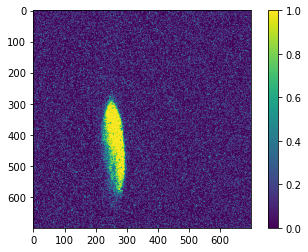

In [9]:
img_object= Image(images[0,:,:],image_name='DYG14_1701969528')
img_object.subtract_image_background(threshold = 250)
img = img_object.image

In [10]:
transformer = Transformer_1D(img_object.x_projection,transform_type = 'normalize')

In [11]:
x_projection_normed = transformer.forward(transformer.data)
transformer.recalculate(img_object.y_projection)
y_projection_normed = transformer.forward(transformer.data)

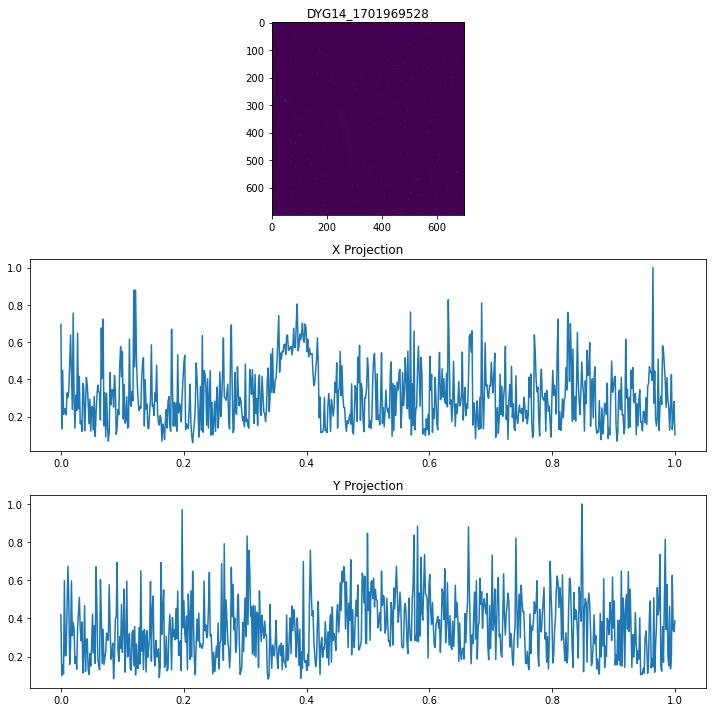

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1,figsize=(10,10))
ax1.imshow(img)
ax1.set_title(img_object.image_name)

ax2_linspace = np.linspace(0,1,len(x_projection_normed))
ax2.plot(ax2_linspace,x_projection_normed)
ax2.set_title('X Projection')

ax3_linspace = np.linspace(0,1,len(y_projection_normed))
ax3.plot(ax3_linspace,y_projection_normed)
ax3.set_title('Y Projection')

fig.tight_layout()

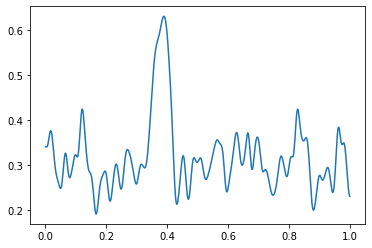

In [27]:
smoothed_x = gaussian_filter(x_projection_normed,sigma =5)
fig = plt.plot()
plt.plot(ax2_linspace,smoothed_x)

In [13]:
model_x = GaussianModel(x_projection_normed)

0.9393972579511292 0.9628571428571429 0.1 0.06060274204887079


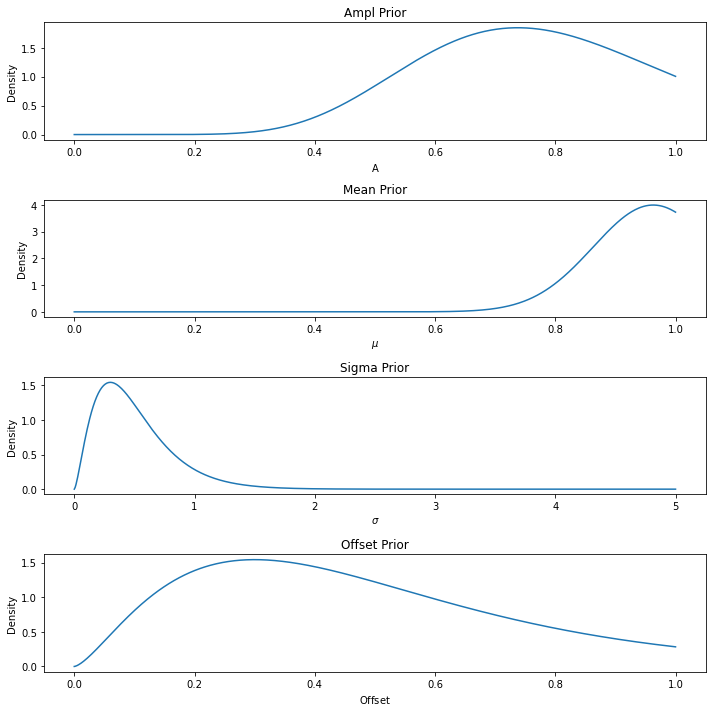

In [14]:
model_x.plot_priors()


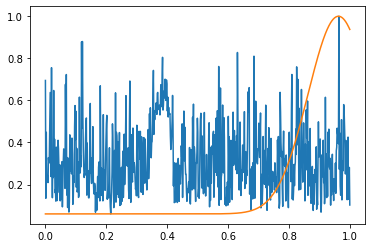

In [15]:
model_x.plot_initial_guess()

Fitted model parameters:
[0.51887878 0.38691517 0.02001592 0.29121873]
100
15
33.82312666611089


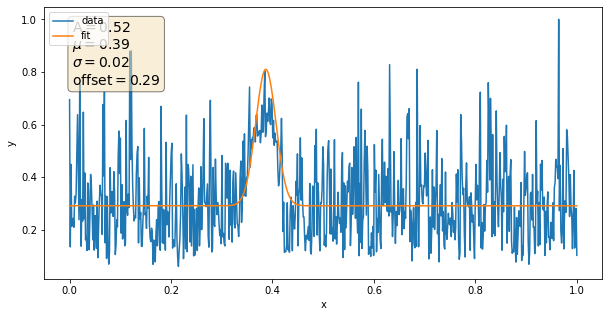

In [16]:
use_priors = True
x_projection_linspace = np.linspace(0,1,len(x_projection_normed))
res=fit_model(x_projection_linspace,x_projection_normed,model_x,use_priors, plot = True)
print('Fitted model parameters:')
print(res.x)
print(res.nfev)
print(res.nit)
print(res.fun)
#fit_params_x = untransform(res.x,x_proj)
#('Fitted model parameters after untransforming:')
#print(fit_params_x)

In [17]:
model_y = GaussianModel(y_projection_normed)

0.9179170792393428 0.8471428571428572 0.1 0.08208292076065714


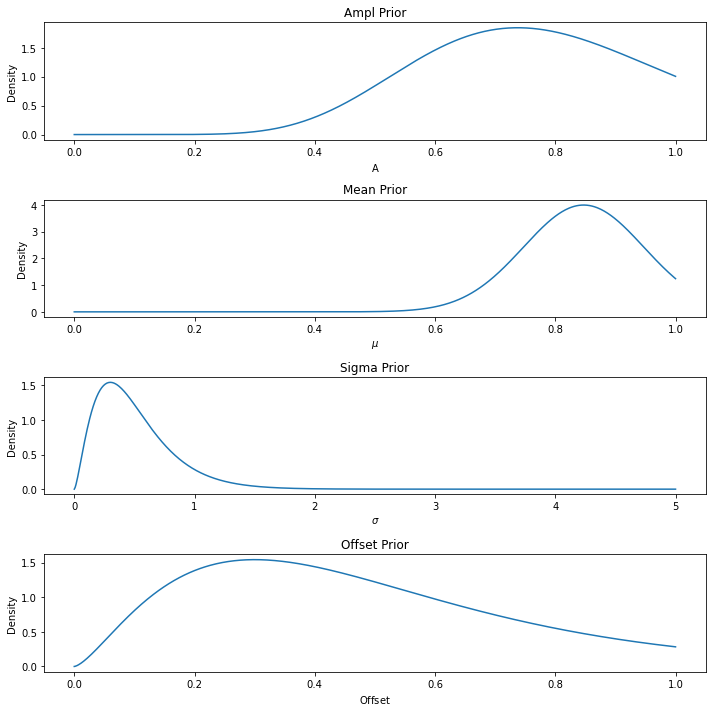

In [18]:
model_y.plot_priors()

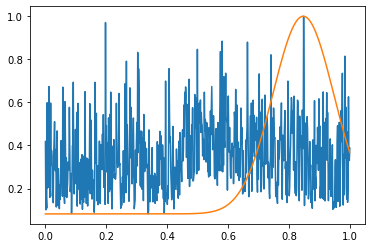

In [19]:
model_y.plot_initial_guess()

Fitted model parameters:
[0.40263735 0.79569382 0.733834   0.01      ]
140
24
19.405947887662144


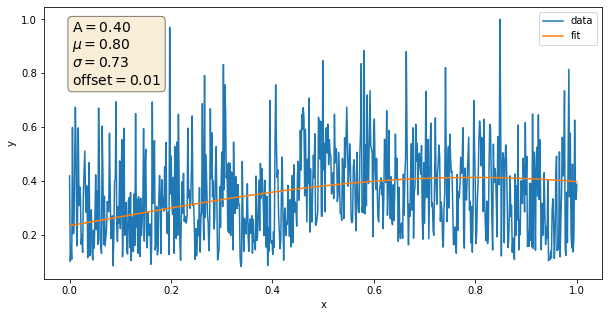

In [20]:
y_projection_linspace = np.linspace(0,1,len(x_projection_normed))
res=fit_model(y_projection_linspace,y_projection_normed,model_y,use_priors, plot = True)
print('Fitted model parameters:')
print(res.x)
print(res.nfev)
print(res.nit)
print(res.fun)